# 🔧 Credit Card Default Prediction - Feature Engineering

This notebook focuses on creating meaningful features from raw data to improve model performance. Based on insights from our exploratory data analysis, we'll engineer features that capture financial behavior, payment patterns, and risk indicators.

## 🎯 Objectives
1. **Create financial stability indicators** (utilization, payment consistency)
2. **Engineer delinquency patterns** (streaks, trends, severity)
3. **Build payment behavior features** (gaps, volatility, trends)
4. **Develop interaction features** between demographics and finance
5. **Select optimal feature set** for modeling

## 📋 Feature Categories
- **Credit Utilization**: Ratios, headroom, volatility
- **Payment Behavior**: Gaps, consistency, trends
- **Delinquency Patterns**: Counts, streaks, severity
- **Financial Stability**: Composite scores, risk flags
- **Temporal Features**: Trends, acceleration, seasonality

In [23]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import sys
import os

# Add src directory to path
sys.path.append('../src')
from feature_engineering import FeatureEngineer
from data_preprocessing import load_and_preprocess_data

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load preprocessed data
print("Loading and preprocessing data...")
train_data, _, metadata = load_and_preprocess_data("../data/train.csv")
print(f"Data loaded: {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")

Libraries imported successfully!
Loading and preprocessing data...
Loading training data...
Data loaded successfully: 25247 rows, 27 columns
Starting data preprocessing...
Column validation completed. Found 27 expected columns.
Missing values found:
age    126
dtype: int64
Filled age missing values with median: 34.0
Found 23061 invalid values in pay_amt1
Found 22959 invalid values in pay_amt2
Found 22695 invalid values in pay_amt3
Found 22540 invalid values in pay_amt4
Found 22391 invalid values in pay_amt5
Found 22143 invalid values in pay_amt6
Found 136 records with extreme payment ratios (>5)
Preprocessing completed. Shape: (25247, 27) -> (25247, 30)
Data loaded: (25247, 30)
Columns: ['Customer_ID', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default', 'sex_

In [24]:
# Data Overview and Setup
df = train_data.copy()
target_col = 'next_month_default'

print("🔍 Dataset Overview")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Target variable: {target_col}")
print(f"Default rate: {df[target_col].mean():.3f} ({df[target_col].mean()*100:.1f}%)")

# Identify column types
bill_cols = [col for col in df.columns if col.startswith('Bill_amt')]
pay_cols = [col for col in df.columns if col.startswith('pay_amt')]
pay_status_cols = [col for col in df.columns if col.startswith('pay_') and 'amt' not in col]

print(f"\n📊 Column Categories:")
print(f"Bill amount columns: {bill_cols}")
print(f"Payment amount columns: {pay_cols}")
print(f"Payment status columns: {pay_status_cols}")
print(f"Basic features: {[col for col in df.columns if col not in bill_cols + pay_cols + pay_status_cols and col != target_col]}")

# Check for missing values
missing_info = df.isnull().sum()
if missing_info.sum() > 0:
    print(f"\n⚠️ Missing Values Found:")
    for col, missing in missing_info.items():
        if missing > 0:
            print(f"  {col}: {missing} ({missing/len(df)*100:.1f}%)")
else:
    print("\n✅ No missing values found!")

# Display basic statistics
print(f"\n📈 Basic Statistics:")
print(df.describe())

🔍 Dataset Overview
Dataset shape: (25247, 30)
Target variable: next_month_default
Default rate: 0.190 (19.0%)

📊 Column Categories:
Bill amount columns: ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
Payment amount columns: ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
Payment status columns: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
Basic features: ['Customer_ID', 'LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'sex_Male', 'education_High_School', 'education_Others', 'education_University', 'marriage_Others', 'marriage_Single']

✅ No missing values found!

📈 Basic Statistics:
        Customer_ID       LIMIT_BAL           age         pay_0         pay_2  \
count  25247.000000    25247.000000  25247.000000  25247.000000  25247.000000   
mean   17640.000000   168342.060443     35.431022     -0.042857     -0.159544   
std     7288.325459   129892.784807      9.152635      1.099315      1.173990   
min     501

## 💳 1. Credit Utilization Features

Credit utilization is one of the most important factors in credit risk assessment. We'll create comprehensive utilization features including ratios, trends, and volatility measures.

In [25]:
# 1. Credit Utilization Features
print("💳 Creating Credit Utilization Features...")

# Basic utilization ratio (already exists in data)
if 'PAY_TO_BILL_ratio' in df.columns:
    print("✓ PAY_TO_BILL_ratio already exists")

# Enhanced credit utilization features
# 1.1 Current utilization ratio
df['credit_utilization_ratio'] = df['AVG_Bill_amt'] / (df['LIMIT_BAL'] + 1e-8)
df['credit_utilization_ratio'] = np.clip(df['credit_utilization_ratio'], 0, 5)  # Cap at 500%

# 1.2 Credit headroom (available credit)
df['credit_headroom'] = df['LIMIT_BAL'] - df['AVG_Bill_amt']
df['credit_headroom_ratio'] = df['credit_headroom'] / (df['LIMIT_BAL'] + 1e-8)

# 1.3 Utilization categories
df['utilization_category'] = pd.cut(df['credit_utilization_ratio'], 
                                   bins=[0, 0.3, 0.6, 0.9, 1.2, 5],
                                   labels=['Low', 'Medium', 'High', 'Very_High', 'Extreme'],
                                   include_lowest=True)

# 1.4 Monthly bill utilization (individual months)
bill_utilization_features = []
for i, bill_col in enumerate(bill_cols, 1):
    util_col = f'bill_utilization_m{i}'
    df[util_col] = df[bill_col] / (df['LIMIT_BAL'] + 1e-8)
    df[util_col] = np.clip(df[util_col], 0, 5)
    bill_utilization_features.append(util_col)

# 1.5 Utilization volatility and trends
if len(bill_utilization_features) >= 3:
    df['utilization_std'] = df[bill_utilization_features].std(axis=1)
    df['utilization_mean'] = df[bill_utilization_features].mean(axis=1)
    df['utilization_cv'] = df['utilization_std'] / (df['utilization_mean'] + 1e-8)
    
    # Utilization trend (recent vs old)
    recent_util = df[bill_utilization_features[:3]].mean(axis=1)
    old_util = df[bill_utilization_features[-3:]].mean(axis=1)
    df['utilization_trend'] = recent_util - old_util
    
    # Max and min utilization
    df['max_utilization'] = df[bill_utilization_features].max(axis=1)
    df['min_utilization'] = df[bill_utilization_features].min(axis=1)
    df['utilization_range'] = df['max_utilization'] - df['min_utilization']

# 1.6 Credit limit adequacy
df['limit_per_age'] = df['LIMIT_BAL'] / (df['age'] + 1e-8)
df['limit_adequacy'] = np.where(df['credit_utilization_ratio'] > 0.8, 0, 1)  # Binary flag

print(f"✅ Created {len([col for col in df.columns if 'utilization' in col or 'credit_' in col or 'limit_' in col]) - 1} credit utilization features")

# Display sample of utilization features
util_features = [col for col in df.columns if 'utilization' in col or 'credit_' in col or 'limit_' in col]
print(f"\nCreated features: {util_features}")
print(f"\nSample statistics:")
print(df[util_features[:5]].describe())

💳 Creating Credit Utilization Features...
✓ PAY_TO_BILL_ratio already exists
✅ Created 18 credit utilization features

Created features: ['credit_utilization_ratio', 'credit_headroom', 'credit_headroom_ratio', 'utilization_category', 'bill_utilization_m1', 'bill_utilization_m2', 'bill_utilization_m3', 'bill_utilization_m4', 'bill_utilization_m5', 'bill_utilization_m6', 'utilization_std', 'utilization_mean', 'utilization_cv', 'utilization_trend', 'max_utilization', 'min_utilization', 'utilization_range', 'limit_per_age', 'limit_adequacy']

Sample statistics:
       credit_utilization_ratio  credit_headroom  credit_headroom_ratio  \
count              25247.000000     25247.000000           25247.000000   
mean                   0.370520    123482.412958               0.629565   
std                    0.349350    126044.896513               0.349451   
min                    0.000000   -235502.670000              -2.759125   
25%                    0.029802     20156.500000             

## 💰 2. Payment Behavior Features

Payment behavior is crucial for understanding creditworthiness. We'll analyze payment gaps, consistency, patterns, and trends.

In [26]:
# 2. Payment Behavior Features
print("💰 Creating Payment Behavior Features...")

# 2.1 Payment gaps (bill - payment)
payment_gap_features = []
for i in range(min(len(bill_cols), len(pay_cols))):
    gap_col = f'payment_gap_m{i+1}'
    df[gap_col] = df[bill_cols[i]] - df[pay_cols[i]]
    payment_gap_features.append(gap_col)

# 2.2 Payment ratios (payment / bill)
payment_ratio_features = []
for i in range(min(len(bill_cols), len(pay_cols))):
    ratio_col = f'payment_ratio_m{i+1}'
    df[ratio_col] = df[pay_cols[i]] / (df[bill_cols[i]] + 1e-8)
    df[ratio_col] = np.clip(df[ratio_col], 0, 10)  # Cap at 1000%
    payment_ratio_features.append(ratio_col)

# 2.3 Aggregate payment behavior metrics
if len(payment_gap_features) >= 3:
    # Payment gaps
    df['avg_payment_gap'] = df[payment_gap_features].mean(axis=1)
    df['payment_gap_std'] = df[payment_gap_features].std(axis=1)
    df['max_payment_gap'] = df[payment_gap_features].max(axis=1)
    df['min_payment_gap'] = df[payment_gap_features].min(axis=1)
    
    # Payment ratios
    df['avg_payment_ratio'] = df[payment_ratio_features].mean(axis=1)
    df['payment_ratio_std'] = df[payment_ratio_features].std(axis=1)
    df['min_payment_ratio'] = df[payment_ratio_features].min(axis=1)
    
    # Payment consistency
    df['payment_consistency'] = df['payment_ratio_std'] / (df['avg_payment_ratio'] + 1e-8)
    
    # Payment trend (recent vs old)
    recent_payments = df[pay_cols[:3]].mean(axis=1)
    old_payments = df[pay_cols[-3:]].mean(axis=1)
    df['payment_trend'] = recent_payments - old_payments
    
    # Recent vs old bills
    recent_bills = df[bill_cols[:3]].mean(axis=1)
    old_bills = df[bill_cols[-3:]].mean(axis=1)
    df['bill_trend'] = recent_bills - old_bills

# 2.4 Payment behavior patterns
# Zero payment months
df['zero_payment_months'] = (df[pay_cols] == 0).sum(axis=1)
df['zero_payment_pct'] = df['zero_payment_months'] / len(pay_cols)

# Full payment months (payment >= 95% of bill)
full_payment_count = 0
for i in range(min(len(bill_cols), len(pay_cols))):
    full_payment_count += (df[pay_cols[i]] >= 0.95 * df[bill_cols[i]]).astype(int)
df['full_payment_months'] = full_payment_count
df['full_payment_pct'] = df['full_payment_months'] / len(pay_cols)

# Minimal payment months (payment < 10% of bill but > 0)
minimal_payment_count = 0
for i in range(min(len(bill_cols), len(pay_cols))):
    minimal_payment_count += ((df[pay_cols[i]] > 0) & (df[pay_cols[i]] < 0.1 * df[bill_cols[i]])).astype(int)
df['minimal_payment_months'] = minimal_payment_count
df['minimal_payment_pct'] = df['minimal_payment_months'] / len(pay_cols)

# 2.5 Payment behavior classification
def classify_payment_behavior(row):
    if row['zero_payment_pct'] >= 0.5:
        return 'Non_Payer'
    elif row['full_payment_pct'] >= 0.67:
        return 'Full_Payer'
    elif row['avg_payment_ratio'] >= 0.3:
        return 'Partial_Payer'
    elif row['minimal_payment_pct'] >= 0.5:
        return 'Minimal_Payer'
    else:
        return 'Irregular_Payer'

df['payment_behavior_type'] = df.apply(classify_payment_behavior, axis=1)

# 2.6 Payment amount volatility
if len(pay_cols) >= 3:
    df['payment_amount_mean'] = df[pay_cols].mean(axis=1)
    df['payment_amount_std'] = df[pay_cols].std(axis=1)
    df['payment_amount_cv'] = df['payment_amount_std'] / (df['payment_amount_mean'] + 1e-8)
    df['payment_amount_range'] = df[pay_cols].max(axis=1) - df[pay_cols].min(axis=1)

print(f"✅ Created payment behavior features")

# Display sample of payment features
payment_features = [col for col in df.columns if 'payment' in col and col not in pay_cols]
print(f"\nCreated {len(payment_features)} payment behavior features")
print(f"Sample features: {payment_features[:8]}")
print(f"\nPayment behavior distribution:")
print(df['payment_behavior_type'].value_counts())

💰 Creating Payment Behavior Features...
✅ Created payment behavior features

Created 32 payment behavior features
Sample features: ['payment_gap_m1', 'payment_gap_m2', 'payment_gap_m3', 'payment_gap_m4', 'payment_gap_m5', 'payment_gap_m6', 'payment_ratio_m1', 'payment_ratio_m2']

Payment behavior distribution:
payment_behavior_type
Minimal_Payer      11111
Partial_Payer       7315
Non_Payer           4734
Irregular_Payer     1454
Full_Payer           633
Name: count, dtype: int64
✅ Created payment behavior features

Created 32 payment behavior features
Sample features: ['payment_gap_m1', 'payment_gap_m2', 'payment_gap_m3', 'payment_gap_m4', 'payment_gap_m5', 'payment_gap_m6', 'payment_ratio_m1', 'payment_ratio_m2']

Payment behavior distribution:
payment_behavior_type
Minimal_Payer      11111
Partial_Payer       7315
Non_Payer           4734
Irregular_Payer     1454
Full_Payer           633
Name: count, dtype: int64


## 🚨 3. Delinquency Pattern Features

Delinquency patterns provide critical insights into payment discipline and risk behavior. We'll analyze payment delays, streaks, and severity.

In [27]:
# 3. Delinquency Pattern Features
print("🚨 Creating Delinquency Pattern Features...")

# 3.1 Basic delinquency metrics
df['delinquency_count'] = (df[pay_status_cols] >= 1).sum(axis=1)
df['severe_delinquency_count'] = (df[pay_status_cols] >= 3).sum(axis=1)
df['max_delinquency'] = df[pay_status_cols].max(axis=1)
df['min_delinquency'] = df[pay_status_cols].min(axis=1)

# 3.2 Delinquency ratios
df['delinquency_ratio'] = df['delinquency_count'] / len(pay_status_cols)
df['severe_delinquency_ratio'] = df['severe_delinquency_count'] / len(pay_status_cols)

# 3.3 Recent vs historical delinquency
recent_delinq_cols = pay_status_cols[:3] if len(pay_status_cols) >= 3 else pay_status_cols
old_delinq_cols = pay_status_cols[-3:] if len(pay_status_cols) >= 3 else []

df['recent_delinquency_count'] = (df[recent_delinq_cols] >= 1).sum(axis=1)
if old_delinq_cols:
    df['old_delinquency_count'] = (df[old_delinq_cols] >= 1).sum(axis=1)
    df['delinquency_trend'] = df['recent_delinquency_count'] - df['old_delinquency_count']
else:
    df['old_delinquency_count'] = 0
    df['delinquency_trend'] = df['recent_delinquency_count']

# 3.4 Delinquency streaks and patterns
def calculate_delinquency_streak(row):
    """Calculate longest consecutive delinquency streak"""
    pay_status = [row[col] for col in pay_status_cols]
    max_streak = 0
    current_streak = 0
    
    for status in pay_status:
        if status >= 1:  # Delinquent
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    
    return max_streak

df['max_delinquency_streak'] = df.apply(calculate_delinquency_streak, axis=1)

# 3.5 Current delinquency status (most recent)
df['current_delinquency_status'] = df[pay_status_cols[0]] if pay_status_cols else 0
df['is_currently_delinquent'] = (df['current_delinquency_status'] >= 1).astype(int)

# 3.6 Delinquency severity categories
def categorize_delinquency_severity(row):
    if row['max_delinquency'] == 0:
        return 'No_Delinquency'
    elif row['max_delinquency'] == 1:
        return 'Mild_Delinquency'
    elif row['max_delinquency'] == 2:
        return 'Moderate_Delinquency'
    elif row['max_delinquency'] >= 3:
        return 'Severe_Delinquency'
    else:
        return 'Unknown'

df['delinquency_severity_category'] = df.apply(categorize_delinquency_severity, axis=1)

# 3.7 Payment status volatility
df['payment_status_std'] = df[pay_status_cols].std(axis=1)
df['payment_status_range'] = df[pay_status_cols].max(axis=1) - df[pay_status_cols].min(axis=1)

# 3.8 Advanced delinquency patterns
# Escalating delinquency (getting worse over time)
pay_status_values = df[pay_status_cols].values
df['escalating_delinquency'] = 0
for i in range(len(df)):
    row_values = pay_status_values[i]
    if len(row_values) >= 3:
        recent_avg = np.mean(row_values[:3])
        old_avg = np.mean(row_values[-3:])
        df.loc[i, 'escalating_delinquency'] = int(recent_avg > old_avg)

# De-escalating delinquency (improving over time)
df['deescalating_delinquency'] = 0
for i in range(len(df)):
    row_values = pay_status_values[i]
    if len(row_values) >= 3:
        recent_avg = np.mean(row_values[:3])
        old_avg = np.mean(row_values[-3:])
        df.loc[i, 'deescalating_delinquency'] = int(recent_avg < old_avg and old_avg > 0)

print(f"✅ Created delinquency pattern features")

# Display delinquency feature summary
delinq_features = [col for col in df.columns if 'delinq' in col or 'current_' in col or 'escalat' in col]
print(f"\nCreated {len(delinq_features)} delinquency features")
print(f"Sample features: {delinq_features[:8]}")
print(f"\nDelinquency severity distribution:")
print(df['delinquency_severity_category'].value_counts())
print(f"\nBasic delinquency statistics:")
print(f"Average delinquency count: {df['delinquency_count'].mean():.2f}")
print(f"Customers with no delinquency: {(df['delinquency_count'] == 0).sum():,} ({(df['delinquency_count'] == 0).mean()*100:.1f}%)")
print(f"Customers with severe delinquency: {(df['max_delinquency'] >= 3).sum():,} ({(df['max_delinquency'] >= 3).mean()*100:.1f}%)")

🚨 Creating Delinquency Pattern Features...
✅ Created delinquency pattern features

Created 15 delinquency features
Sample features: ['delinquency_count', 'severe_delinquency_count', 'max_delinquency', 'min_delinquency', 'delinquency_ratio', 'severe_delinquency_ratio', 'recent_delinquency_count', 'old_delinquency_count']

Delinquency severity distribution:
delinquency_severity_category
No_Delinquency          12686
Moderate_Delinquency     5795
Unknown                  4434
Mild_Delinquency         1424
Severe_Delinquency        908
Name: count, dtype: int64

Basic delinquency statistics:
Average delinquency count: 0.79
Customers with no delinquency: 17,120 (67.8%)
Customers with severe delinquency: 908 (3.6%)
✅ Created delinquency pattern features

Created 15 delinquency features
Sample features: ['delinquency_count', 'severe_delinquency_count', 'max_delinquency', 'min_delinquency', 'delinquency_ratio', 'severe_delinquency_ratio', 'recent_delinquency_count', 'old_delinquency_count']

D

## 💼 4. Financial Stability Features

Financial stability indicators help assess overall creditworthiness through composite scores and stability measures.

In [28]:
# 4. Financial Stability Features
print("💼 Creating Financial Stability Features...")

# 4.1 Bill amount stability
if len(bill_cols) >= 3:
    df['bill_amount_mean'] = df[bill_cols].mean(axis=1)
    df['bill_amount_std'] = df[bill_cols].std(axis=1)
    df['bill_amount_cv'] = df['bill_amount_std'] / (df['bill_amount_mean'] + 1e-8)
    df['bill_amount_range'] = df[bill_cols].max(axis=1) - df[bill_cols].min(axis=1)
    df['bill_stability_score'] = 1 / (1 + df['bill_amount_cv'])  # Higher = more stable

# 4.2 Financial stress indicators
df['high_utilization_flag'] = (df['credit_utilization_ratio'] > 0.8).astype(int)
df['chronic_delinquency_flag'] = (df['delinquency_count'] >= 3).astype(int)
df['payment_struggle_flag'] = (df['avg_payment_ratio'] < 0.2).astype(int)
df['zero_payment_flag'] = (df['zero_payment_months'] >= 2).astype(int)

# 4.3 Composite financial health score
# Normalize key metrics to 0-1 scale for scoring
from sklearn.preprocessing import MinMaxScaler

# Create temporary features for scoring
temp_features = ['credit_utilization_ratio', 'delinquency_ratio', 'payment_consistency', 'avg_payment_ratio']
available_features = [f for f in temp_features if f in df.columns]

if len(available_features) >= 3:
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[available_features])
    
    # Calculate financial health score (higher = better)
    utilization_penalty = 1 - scaled_features[:, 0]  # Lower utilization is better
    delinquency_penalty = 1 - scaled_features[:, 1]  # Lower delinquency is better
    payment_consistency_score = 1 - np.clip(scaled_features[:, 2], 0, 1)  # Lower volatility is better
    payment_ratio_score = scaled_features[:, 3]  # Higher payment ratio is better
    
    df['financial_health_score'] = (
        utilization_penalty * 0.3 + 
        delinquency_penalty * 0.3 + 
        payment_consistency_score * 0.2 + 
        payment_ratio_score * 0.2
    )

# 4.4 Risk flags combinations
df['multiple_risk_flags'] = (
    df['high_utilization_flag'] + 
    df['chronic_delinquency_flag'] + 
    df['payment_struggle_flag'] + 
    df['zero_payment_flag']
)

df['high_risk_customer'] = (df['multiple_risk_flags'] >= 2).astype(int)

# 4.5 Credit limit to age ratio (financial capacity)
df['credit_limit_age_ratio'] = df['LIMIT_BAL'] / (df['age'] + 1e-8)

# 4.6 Balance trajectory (are bills increasing or decreasing?)
if len(bill_cols) >= 6:
    recent_bills = df[bill_cols[:3]].mean(axis=1)
    old_bills = df[bill_cols[-3:]].mean(axis=1)
    df['bill_trajectory'] = (recent_bills - old_bills) / (old_bills + 1e-8)
    df['increasing_bills_flag'] = (df['bill_trajectory'] > 0.1).astype(int)

# 4.7 Payment efficiency metrics
if 'avg_payment_gap' in df.columns and 'avg_payment_ratio' in df.columns:
    # Payment efficiency: how well they manage payment vs bill amounts
    df['payment_efficiency'] = df['avg_payment_ratio'] / (df['avg_payment_gap'] / df['LIMIT_BAL'] + 1e-8)
    df['payment_efficiency'] = np.clip(df['payment_efficiency'], 0, 10)

# 4.8 Demographic risk factors (only if columns exist)
# Education risk (based on domain knowledge)
if 'education' in df.columns:
    education_risk_map = {1: 0.1, 2: 0.2, 3: 0.3, 4: 0.4, 5: 0.5, 6: 0.6}  # Lower education = higher risk
    df['education_risk_score'] = df['education'].map(education_risk_map).fillna(0.5)
else:
    print("Education column not found, skipping education risk score")
    df['education_risk_score'] = 0.3  # Default moderate risk

# Age risk (younger and very old may be riskier)
if 'age' in df.columns:
    df['age_risk_score'] = np.where(df['age'] < 25, 0.6, 
                                    np.where(df['age'] > 65, 0.5, 0.3))
else:
    print("Age column not found, skipping age risk score")
    df['age_risk_score'] = 0.3  # Default moderate risk

# Marriage stability (married generally more stable)
if 'marriage' in df.columns:
    marriage_risk_map = {1: 0.2, 2: 0.4, 3: 0.5}  # Married < Single < Others
    df['marriage_risk_score'] = df['marriage'].map(marriage_risk_map).fillna(0.4)
else:
    print("Marriage column not found, skipping marriage risk score")
    df['marriage_risk_score'] = 0.4  # Default moderate risk

# 4.9 Overall risk composite score
risk_components = ['education_risk_score', 'age_risk_score', 'marriage_risk_score']
if 'financial_health_score' in df.columns:
    df['overall_risk_score'] = (
        df['education_risk_score'] * 0.2 + 
        df['age_risk_score'] * 0.2 + 
        df['marriage_risk_score'] * 0.1 + 
        (1 - df['financial_health_score']) * 0.5  # Financial health contributes most
    )
else:
    df['overall_risk_score'] = (
        df['education_risk_score'] * 0.4 + 
        df['age_risk_score'] * 0.3 + 
        df['marriage_risk_score'] * 0.3
    )

print(f"✅ Created financial stability features")

# Display financial stability features
stability_features = [col for col in df.columns if any(x in col for x in ['stability', 'health', 'risk_', 'flag', 'efficiency'])]
print(f"\nCreated {len(stability_features)} financial stability features")
print(f"Sample features: {stability_features[:8]}")

if 'financial_health_score' in df.columns:
    print(f"\nFinancial Health Score Distribution:")
    print(f"Mean: {df['financial_health_score'].mean():.3f}")
    print(f"Std: {df['financial_health_score'].std():.3f}")
    print(f"High risk customers (score < 0.3): {(df['financial_health_score'] < 0.3).sum():,} ({(df['financial_health_score'] < 0.3).mean()*100:.1f}%)")

print(f"\nRisk flags summary:")
for flag in ['high_utilization_flag', 'chronic_delinquency_flag', 'payment_struggle_flag', 'zero_payment_flag']:
    if flag in df.columns:
        count = df[flag].sum()
        pct = df[flag].mean() * 100
        print(f"{flag}: {count:,} customers ({pct:.1f}%)")

💼 Creating Financial Stability Features...
Education column not found, skipping education risk score
Marriage column not found, skipping marriage risk score
✅ Created financial stability features

Created 14 financial stability features
Sample features: ['bill_stability_score', 'high_utilization_flag', 'chronic_delinquency_flag', 'payment_struggle_flag', 'zero_payment_flag', 'financial_health_score', 'multiple_risk_flags', 'high_risk_customer']

Financial Health Score Distribution:
Mean: 0.667
Std: 0.104
High risk customers (score < 0.3): 68 (0.3%)

Risk flags summary:
high_utilization_flag: 4,204 customers (16.7%)
chronic_delinquency_flag: 2,933 customers (11.6%)
payment_struggle_flag: 14,334 customers (56.8%)
zero_payment_flag: 7,529 customers (29.8%)


## 🔄 5. Interaction & Temporal Features

Creating interaction features between different variables and temporal patterns to capture complex relationships.

In [29]:
# 5. Interaction & Temporal Features
print("🔄 Creating Interaction & Temporal Features...")

# 5.1 Demographic-Financial Interactions
# Age-Income proxy interaction (limit_bal as income proxy)
df['age_income_interaction'] = df['age'] * np.log1p(df['LIMIT_BAL'])
df['young_high_limit'] = ((df['age'] < 30) & (df['LIMIT_BAL'] > df['LIMIT_BAL'].median())).astype(int)
df['old_low_limit'] = ((df['age'] > 60) & (df['LIMIT_BAL'] < df['LIMIT_BAL'].quantile(0.25))).astype(int)

# Education-Financial interactions (check if education column exists)
if 'education' in df.columns:
    df['education_utilization_interaction'] = df['education'] * df['credit_utilization_ratio']
    df['high_edu_high_util'] = ((df['education'] <= 2) & (df['credit_utilization_ratio'] > 0.7)).astype(int)
    df['low_edu_high_delinq'] = ((df['education'] >= 4) & (df['delinquency_count'] >= 2)).astype(int)
else:
    print("Education column not found - skipping education interactions")

# Marriage-Financial interactions (check if marriage column exists)
if 'marriage' in df.columns:
    df['marriage_payment_interaction'] = df['marriage'] * df['avg_payment_ratio'] if 'avg_payment_ratio' in df.columns else 0
    if 'overall_risk_score' in df.columns:
        df['single_high_risk'] = ((df['marriage'] == 2) & (df['overall_risk_score'] > df['overall_risk_score'].median())).astype(int)
else:
    print("Marriage column not found - skipping marriage interactions")

# 5.2 Utilization-Payment Interactions
if 'credit_utilization_ratio' in df.columns and 'avg_payment_ratio' in df.columns:
    df['util_payment_interaction'] = df['credit_utilization_ratio'] * df['avg_payment_ratio']
    df['high_util_low_payment'] = ((df['credit_utilization_ratio'] > 0.8) & (df['avg_payment_ratio'] < 0.3)).astype(int)
    df['low_util_high_payment'] = ((df['credit_utilization_ratio'] < 0.3) & (df['avg_payment_ratio'] > 0.8)).astype(int)

# 5.3 Bill-Payment Amount Interactions
if len(bill_cols) >= 3 and len(pay_cols) >= 3:
    # Bill-payment volatility interaction
    df['bill_payment_volatility'] = df['bill_amount_cv'] * df['payment_amount_cv'] if 'bill_amount_cv' in df.columns and 'payment_amount_cv' in df.columns else 0
    
    # Large bills with small payments
    df['large_bill_small_payment'] = ((df['AVG_Bill_amt'] > df['AVG_Bill_amt'].quantile(0.75)) & 
                                     (df['payment_amount_mean'] < df['payment_amount_mean'].quantile(0.25))).astype(int)

# 5.4 Temporal Trend Features
if len(bill_cols) >= 6:
    # Monthly bill changes (month-to-month)
    for i in range(len(bill_cols) - 1):
        change_col = f'bill_change_m{i+1}_to_m{i+2}'
        df[change_col] = df[bill_cols[i]] - df[bill_cols[i+1]]
    
    # Monthly payment changes
    for i in range(len(pay_cols) - 1):
        change_col = f'payment_change_m{i+1}_to_m{i+2}'
        df[change_col] = df[pay_cols[i]] - df[pay_cols[i+1]]
    
    # Acceleration features (rate of change of change)
    if len(bill_cols) >= 3:
        df['bill_acceleration'] = (df[bill_cols[0]] - df[bill_cols[1]]) - (df[bill_cols[1]] - df[bill_cols[2]])
        df['payment_acceleration'] = (df[pay_cols[0]] - df[pay_cols[1]]) - (df[pay_cols[1]] - df[pay_cols[2]])

# 5.5 Complex Pattern Features
# Payment pattern consistency (do they pay similar amounts relative to bills?)
if len(pay_cols) >= 3 and len(bill_cols) >= 3:
    payment_patterns = []
    for i in range(min(len(pay_cols), len(bill_cols))):
        pattern = df[pay_cols[i]] / (df[bill_cols[i]] + 1e-8)
        payment_patterns.append(pattern)
    
    payment_pattern_df = pd.DataFrame(payment_patterns).T
    df['payment_pattern_consistency'] = 1 / (1 + payment_pattern_df.std(axis=1))

# 5.6 Seasonal/Cyclical Patterns (if we assume months represent different seasons)
if len(bill_cols) == 6:  # Assuming 6 months of data
    # Split into two seasons
    season1_bills = df[bill_cols[:3]].mean(axis=1)
    season2_bills = df[bill_cols[3:]].mean(axis=1)
    df['seasonal_bill_variation'] = abs(season1_bills - season2_bills) / (season1_bills + season2_bills + 1e-8)
    
    season1_payments = df[pay_cols[:3]].mean(axis=1)
    season2_payments = df[pay_cols[3:]].mean(axis=1)
    df['seasonal_payment_variation'] = abs(season1_payments - season2_payments) / (season1_payments + season2_payments + 1e-8)

# 5.7 Momentum Features (recent trend strength)
if 'bill_trend' in df.columns and 'payment_trend' in df.columns:
    df['positive_momentum'] = ((df['bill_trend'] < 0) & (df['payment_trend'] > 0)).astype(int)  # Decreasing bills, increasing payments
    df['negative_momentum'] = ((df['bill_trend'] > 0) & (df['payment_trend'] < 0)).astype(int)  # Increasing bills, decreasing payments

# 5.8 Risk Clustering Features
# Create risk clusters based on multiple dimensions
risk_features = ['credit_utilization_ratio', 'delinquency_ratio', 'avg_payment_ratio']
available_risk_features = [f for f in risk_features if f in df.columns]

if len(available_risk_features) >= 2:
    from sklearn.cluster import KMeans
    
    # Simple risk clustering
    risk_data = df[available_risk_features].fillna(0)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['risk_cluster'] = kmeans.fit_predict(risk_data)
    
    # Label clusters based on characteristics
    cluster_means = df.groupby('risk_cluster')[available_risk_features].mean()
    df['risk_cluster_label'] = df['risk_cluster'].map({
        0: 'Low_Risk', 1: 'Medium_Risk', 2: 'High_Risk', 3: 'Very_High_Risk'
    })

print(f"✅ Created interaction and temporal features")

# Display interaction features
interaction_features = [col for col in df.columns if any(x in col for x in ['interaction', '_change_', 'acceleration', 'momentum', 'cluster', 'seasonal'])]
print(f"\nCreated {len(interaction_features)} interaction and temporal features")
print(f"Sample features: {interaction_features[:8]}")

if 'risk_cluster' in df.columns:
    print(f"\nRisk cluster distribution:")
    print(df['risk_cluster_label'].value_counts())

# Count all engineered features
original_features = ['Customer_ID', 'LIMIT_BAL', 'age'] + pay_status_cols + bill_cols + pay_cols + ['AVG_Bill_amt', 'PAY_TO_BILL_ratio', target_col]
# Add demographic columns if they exist
if 'marriage' in df.columns:
    original_features.append('marriage')
if 'sex' in df.columns:
    original_features.append('sex')
if 'education' in df.columns:
    original_features.append('education')

engineered_features = [col for col in df.columns if col not in original_features]
print(f"\n🎯 Summary: Created {len(engineered_features)} new features from {len(original_features)-1} original features")

🔄 Creating Interaction & Temporal Features...
Education column not found - skipping education interactions
Marriage column not found - skipping marriage interactions
✅ Created interaction and temporal features

Created 20 interaction and temporal features
Sample features: ['age_income_interaction', 'util_payment_interaction', 'bill_change_m1_to_m2', 'bill_change_m2_to_m3', 'bill_change_m3_to_m4', 'bill_change_m4_to_m5', 'bill_change_m5_to_m6', 'payment_change_m1_to_m2']

Risk cluster distribution:
risk_cluster_label
Medium_Risk       9157
Very_High_Risk    7803
High_Risk         6049
Low_Risk          2238
Name: count, dtype: int64

🎯 Summary: Created 122 new features from 23 original features
✅ Created interaction and temporal features

Created 20 interaction and temporal features
Sample features: ['age_income_interaction', 'util_payment_interaction', 'bill_change_m1_to_m2', 'bill_change_m2_to_m3', 'bill_change_m3_to_m4', 'bill_change_m4_to_m5', 'bill_change_m5_to_m6', 'payment_change

## 🎯 6. Feature Selection & Evaluation

Now we'll evaluate the importance of our engineered features and select the most predictive ones for modeling.

In [30]:
# 6. Feature Selection & Evaluation
print("🎯 Evaluating Feature Importance and Selection...")

# Prepare features for evaluation
# Remove non-numeric features and ID columns
feature_cols = []
for col in df.columns:
    if col not in ['Customer_ID', target_col] and df[col].dtype in ['int64', 'float64']:
        feature_cols.append(col)

# Handle categorical features that were created
categorical_engineered = ['utilization_category', 'payment_behavior_type', 'delinquency_severity_category', 'risk_cluster_label']
for cat_col in categorical_engineered:
    if cat_col in df.columns:
        # One-hot encode categorical features
        dummies = pd.get_dummies(df[cat_col], prefix=cat_col)
        df = pd.concat([df, dummies], axis=1)
        feature_cols.extend(dummies.columns.tolist())

print(f"Total features for evaluation: {len(feature_cols)}")

# 6.1 Basic Feature Correlation with Target
print("\n🔗 Feature Correlations with Target Variable")
print("=" * 60)

feature_correlations = {}
for col in feature_cols:
    if col in df.columns:
        corr = df[col].corr(df[target_col])
        if not np.isnan(corr):
            feature_correlations[col] = abs(corr)

# Sort by correlation strength
sorted_correlations = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by correlation with target:")
for i, (feature, corr) in enumerate(sorted_correlations[:20], 1):
    print(f"{i:2d}. {feature}: {corr:.4f}")

# 6.2 Statistical Feature Selection
print(f"\n📊 Statistical Feature Selection (F-test)")
print("=" * 50)

# Prepare data for statistical tests
X = df[feature_cols].fillna(0)  # Fill NaN with 0 for statistical tests
y = df[target_col]

# Remove infinite values
X = X.replace([np.inf, -np.inf], 0)

# F-test feature selection
selector_f = SelectKBest(score_func=f_classif, k=30)
X_selected_f = selector_f.fit_transform(X, y)
selected_features_f = [feature_cols[i] for i in selector_f.get_support(indices=True)]
feature_scores_f = dict(zip(selected_features_f, selector_f.scores_[selector_f.get_support()]))

print("Top 15 features by F-test score:")
sorted_f_scores = sorted(feature_scores_f.items(), key=lambda x: x[1], reverse=True)
for i, (feature, score) in enumerate(sorted_f_scores[:15], 1):
    print(f"{i:2d}. {feature}: {score:.2f}")

# 6.3 Mutual Information Feature Selection
print(f"\n🎲 Mutual Information Feature Selection")
print("=" * 50)

# Mutual information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=30)
X_selected_mi = selector_mi.fit_transform(X, y)
selected_features_mi = [feature_cols[i] for i in selector_mi.get_support(indices=True)]
feature_scores_mi = dict(zip(selected_features_mi, selector_mi.scores_[selector_mi.get_support()]))

print("Top 15 features by Mutual Information score:")
sorted_mi_scores = sorted(feature_scores_mi.items(), key=lambda x: x[1], reverse=True)
for i, (feature, score) in enumerate(sorted_mi_scores[:15], 1):
    print(f"{i:2d}. {feature}: {score:.4f}")

# 6.4 Feature Importance Ensemble
print(f"\n🏆 Feature Importance Ensemble Ranking")
print("=" * 50)

# Combine different scoring methods
ensemble_scores = {}
for feature in feature_cols:
    if feature in df.columns:
        score = 0
        
        # Correlation score (normalized)
        if feature in feature_correlations:
            score += feature_correlations[feature] * 0.3
        
        # F-test score (normalized)
        if feature in feature_scores_f:
            max_f_score = max(feature_scores_f.values())
            score += (feature_scores_f[feature] / max_f_score) * 0.4
        
        # Mutual information score (normalized)
        if feature in feature_scores_mi:
            max_mi_score = max(feature_scores_mi.values())
            score += (feature_scores_mi[feature] / max_mi_score) * 0.3
        
        ensemble_scores[feature] = score

# Sort by ensemble score
sorted_ensemble = sorted(ensemble_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 25 features by ensemble ranking:")
for i, (feature, score) in enumerate(sorted_ensemble[:25], 1):
    print(f"{i:2d}. {feature}: {score:.4f}")

# 6.5 Feature Categories Analysis
print(f"\n📂 Feature Performance by Category")
print("=" * 50)

feature_categories = {
    'Original': ['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio'],
    'Utilization': [f for f in feature_cols if 'utilization' in f or 'credit_' in f],
    'Payment_Behavior': [f for f in feature_cols if 'payment' in f and f not in pay_cols],
    'Delinquency': [f for f in feature_cols if 'delinq' in f],
    'Financial_Stability': [f for f in feature_cols if any(x in f for x in ['stability', 'health', 'risk_', 'flag'])],
    'Interaction': [f for f in feature_cols if 'interaction' in f or 'momentum' in f],
    'Temporal': [f for f in feature_cols if any(x in f for x in ['trend', 'change', 'acceleration', 'seasonal'])],
    'Individual_Bills': [f for f in bill_cols if f in feature_cols],
    'Individual_Payments': [f for f in pay_cols if f in feature_cols],
    'Payment_Status': [f for f in pay_status_cols if f in feature_cols]
}

category_performance = {}
for category, features in feature_categories.items():
    available_features = [f for f in features if f in ensemble_scores]
    if available_features:
        avg_score = np.mean([ensemble_scores[f] for f in available_features])
        max_score = max([ensemble_scores[f] for f in available_features])
        category_performance[category] = {
            'avg_score': avg_score,
            'max_score': max_score,
            'feature_count': len(available_features),
            'top_feature': max(available_features, key=lambda x: ensemble_scores[x])
        }

# Sort categories by average performance
sorted_categories = sorted(category_performance.items(), key=lambda x: x[1]['avg_score'], reverse=True)

for category, stats in sorted_categories:
    print(f"\n{category}:")
    print(f"  Average Score: {stats['avg_score']:.4f}")
    print(f"  Max Score: {stats['max_score']:.4f}")
    print(f"  Feature Count: {stats['feature_count']}")
    print(f"  Top Feature: {stats['top_feature']} ({ensemble_scores[stats['top_feature']]:.4f})")

# 6.6 Final Feature Set Selection
print(f"\n🎯 Final Feature Set Selection")
print("=" * 50)

# Select top features based on ensemble ranking
top_n_features = 50  # Adjust based on needs
final_feature_set = [feature for feature, score in sorted_ensemble[:top_n_features]]

print(f"Selected {len(final_feature_set)} features for modeling:")
print("\nFinal feature set:")
for i, feature in enumerate(final_feature_set, 1):
    score = ensemble_scores[feature]
    category = 'Unknown'
    for cat, features in feature_categories.items():
        if feature in features:
            category = cat
            break
    print(f"{i:2d}. {feature} ({category}) - Score: {score:.4f}")

# 6.7 Save Feature Engineering Results
print(f"\n💾 Feature Engineering Summary")
print("=" * 50)

feature_summary = {
    'total_original_features': len([col for col in original_features if col != target_col]),
    'total_engineered_features': len(engineered_features),
    'total_final_features': len(final_feature_set),
    'feature_categories_performance': category_performance,
    'top_features': final_feature_set[:20]
}

print(f"Original features: {feature_summary['total_original_features']}")
print(f"Engineered features: {feature_summary['total_engineered_features']}")
print(f"Selected features: {feature_summary['total_final_features']}")
print(f"Feature engineering multiplier: {feature_summary['total_engineered_features'] / feature_summary['total_original_features']:.1f}x")

# Create final dataset
final_dataset = df[['Customer_ID'] + final_feature_set + [target_col]].copy()
print(f"\nFinal dataset shape: {final_dataset.shape}")
print(f"Memory usage: {final_dataset.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n✅ Feature engineering completed successfully!")
print(f"Ready for model training with {len(final_feature_set)} optimized features.")

🎯 Evaluating Feature Importance and Selection...
Total features for evaluation: 152

🔗 Feature Correlations with Target Variable
Top 20 features by correlation with target:
 1. delinquency_count: 0.3896
 2. delinquency_ratio: 0.3896
 3. recent_delinquency_count: 0.3864
 4. max_delinquency_streak: 0.3799
 5. is_currently_delinquent: 0.3552
 6. chronic_delinquency_flag: 0.3352
 7. financial_health_score: 0.3292
 8. max_delinquency: 0.3158
 9. overall_risk_score: 0.3157
10. pay_0: 0.3129
11. current_delinquency_status: 0.3129
12. old_delinquency_count: 0.2995
13. multiple_risk_flags: 0.2843
14. delinquency_severity_category_Moderate_Delinquency: 0.2804
15. delinquency_severity_category_No_Delinquency: 0.2563
16. pay_2: 0.2521
17. high_risk_customer: 0.2461
18. payment_status_std: 0.2341
19. pay_3: 0.2260
20. payment_status_range: 0.2239

📊 Statistical Feature Selection (F-test)
Top 15 features by F-test score:
 1. delinquency_count: 4518.04
 2. delinquency_ratio: 4518.04
 3. recent_delinq

Top 15 features by Mutual Information score:
 1. current_delinquency_status: 0.0709
 2. delinquency_count: 0.0686
 3. delinquency_ratio: 0.0676
 4. pay_0: 0.0670
 5. max_delinquency_streak: 0.0664
 6. recent_delinquency_count: 0.0651
 7. max_delinquency: 0.0592
 8. financial_health_score: 0.0567
 9. overall_risk_score: 0.0536
10. is_currently_delinquent: 0.0497
11. chronic_delinquency_flag: 0.0473
12. multiple_risk_flags: 0.0436
13. pay_2: 0.0411
14. delinquency_severity_category_No_Delinquency: 0.0384
15. old_delinquency_count: 0.0358

🏆 Feature Importance Ensemble Ranking
Top 25 features by ensemble ranking:
 1. delinquency_count: 0.8068
 2. delinquency_ratio: 0.8028
 3. recent_delinquency_count: 0.7835
 4. max_delinquency_streak: 0.7719
 5. is_currently_delinquent: 0.6394
 6. current_delinquency_status: 0.6365
 7. pay_0: 0.6200
 8. financial_health_score: 0.6101
 9. max_delinquency: 0.5925
10. chronic_delinquency_flag: 0.5835
11. overall_risk_score: 0.5691
12. multiple_risk_flags: 0

## 📊 7. Feature Engineering Visualization

📊 Creating Feature Engineering Visualizations...


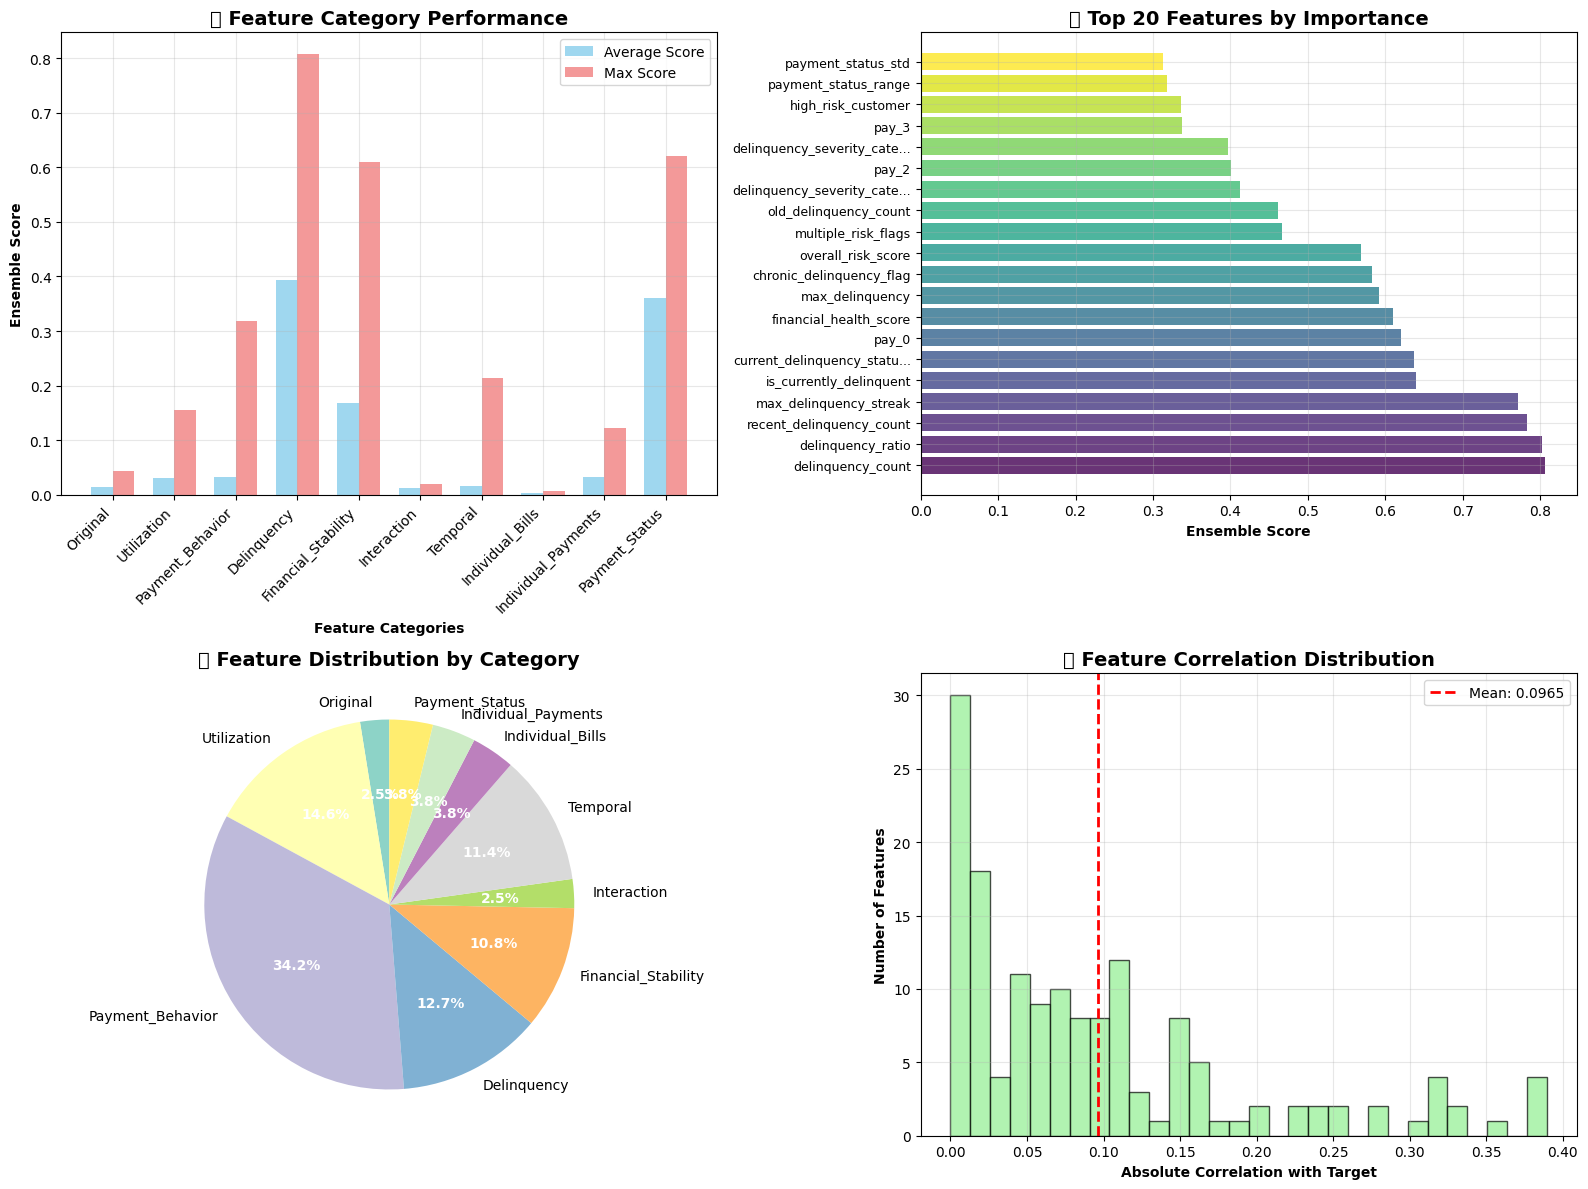

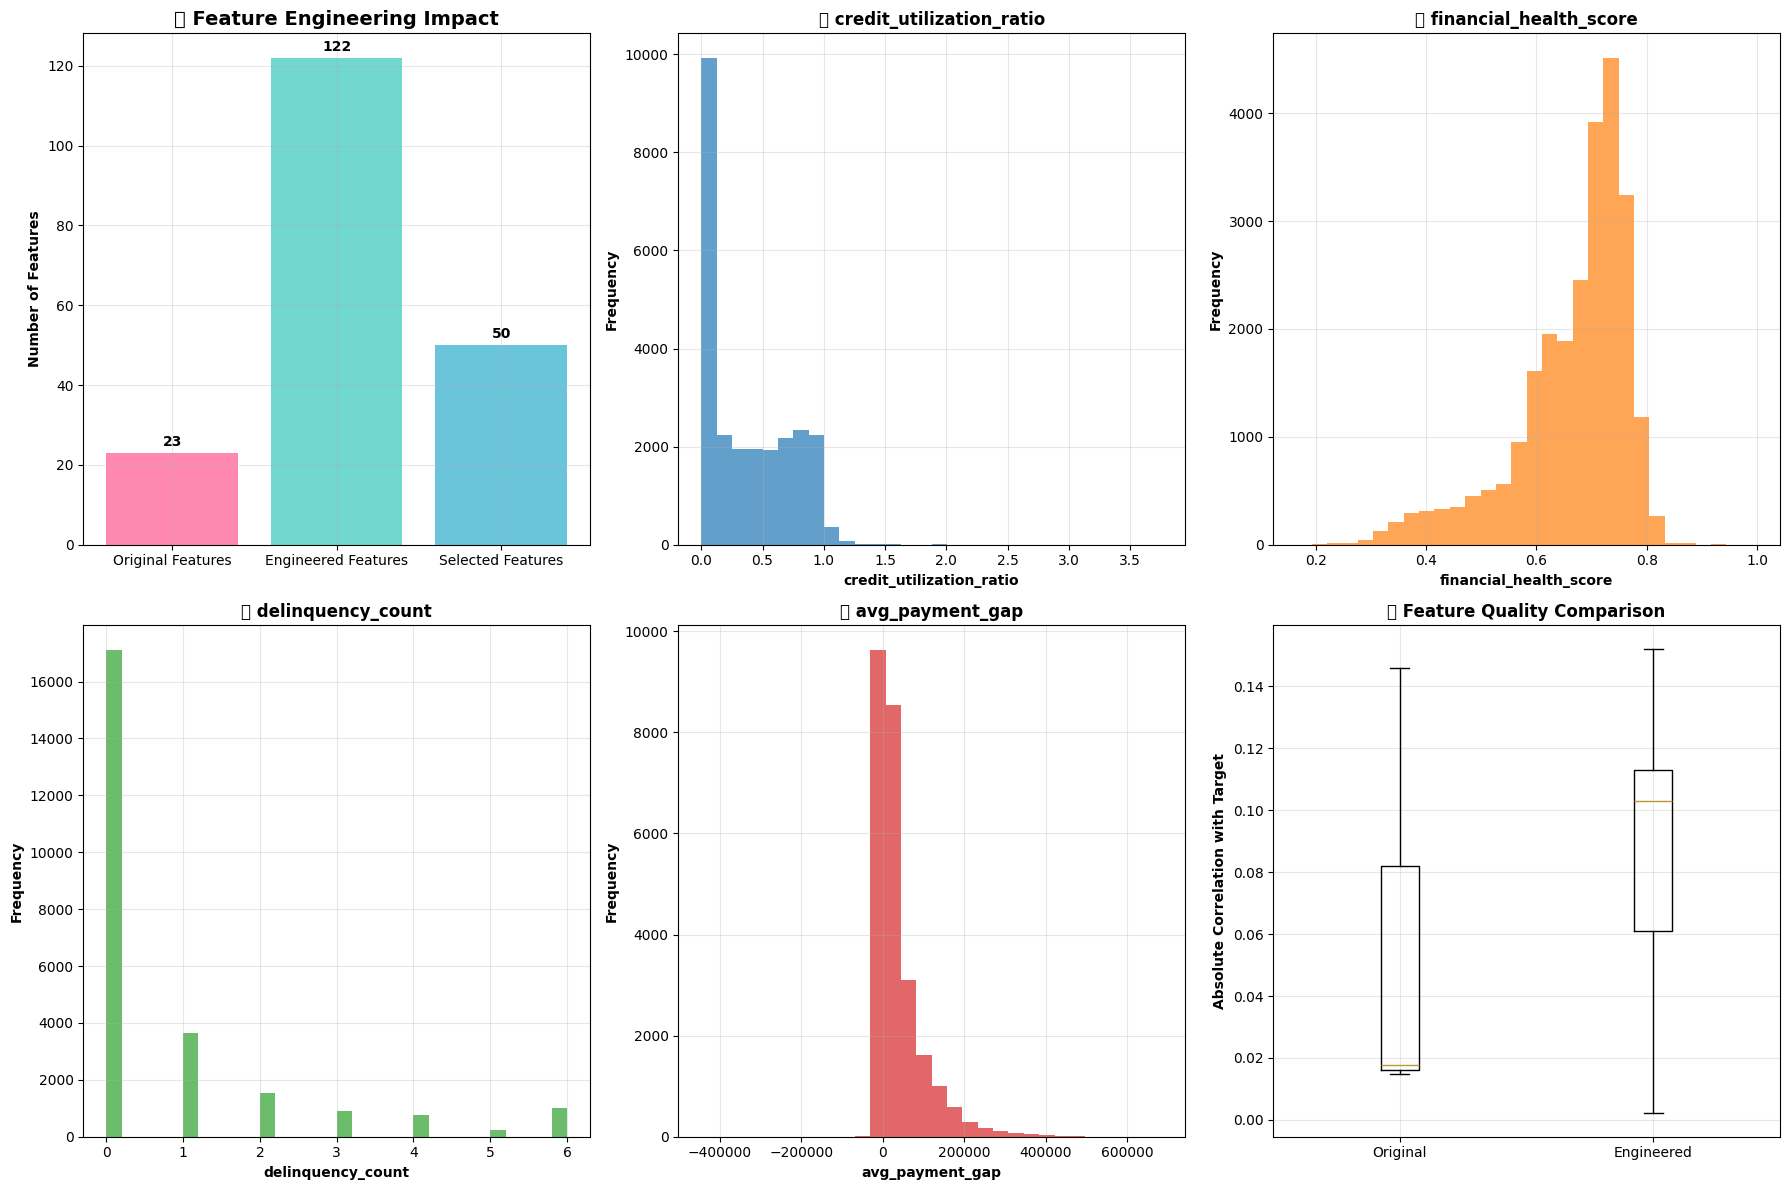


📋 Feature Engineering Summary Report
                      Metric       Value
           Original Features          23
         Engineered Features         122
      Total Features Created         152
           Selected Features          50
             Selection Ratio       32.9%
          Best Feature Score      0.8068
       Average Feature Score      0.0999
          Feature Categories          10
Best Category (by avg score) Delinquency
                Default Rate       19.0%

🎯 Key Insights:
• Created 122 new features from 23 original features
• Selected top 50 features based on ensemble scoring
• Best performing feature category: Delinquency
• Most important feature: delinquency_count (score: 0.8068)
• Dataset ready for machine learning with enhanced predictive features

✅ Feature engineering visualization completed!

Top 10 most important features:
                   Feature  Ensemble_Score  Rank
         delinquency_count        0.806838     1
         delinquency_ratio    

In [31]:
# 7. Feature Engineering Visualization
print("📊 Creating Feature Engineering Visualizations...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# 7.1 Feature Category Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Feature category performance
if category_performance:
    categories = list(category_performance.keys())
    avg_scores = [category_performance[cat]['avg_score'] for cat in categories]
    max_scores = [category_performance[cat]['max_score'] for cat in categories]
    
    x_pos = np.arange(len(categories))
    width = 0.35
    
    bars1 = axes[0,0].bar(x_pos - width/2, avg_scores, width, label='Average Score', alpha=0.8, color='skyblue')
    bars2 = axes[0,0].bar(x_pos + width/2, max_scores, width, label='Max Score', alpha=0.8, color='lightcoral')
    
    axes[0,0].set_xlabel('Feature Categories', fontweight='bold')
    axes[0,0].set_ylabel('Ensemble Score', fontweight='bold')
    axes[0,0].set_title('📊 Feature Category Performance', fontweight='bold', fontsize=14)
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(categories, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Top 20 features importance
if 'sorted_ensemble' in locals():
    top_20_features = [feat for feat, score in sorted_ensemble[:20]]
    top_20_scores = [score for feat, score in sorted_ensemble[:20]]
    
    y_pos = np.arange(len(top_20_features))
    bars = axes[0,1].barh(y_pos, top_20_scores, alpha=0.8, color=plt.cm.viridis(np.linspace(0, 1, len(top_20_features))))
    
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels([feat[:25] + '...' if len(feat) > 25 else feat for feat in top_20_features], fontsize=9)
    axes[0,1].set_xlabel('Ensemble Score', fontweight='bold')
    axes[0,1].set_title('🏆 Top 20 Features by Importance', fontweight='bold', fontsize=14)
    axes[0,1].grid(True, alpha=0.3)

# Plot 3: Feature count by category
if category_performance:
    feature_counts = [category_performance[cat]['feature_count'] for cat in categories]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    wedges, texts, autotexts = axes[1,0].pie(feature_counts, labels=categories, autopct='%1.1f%%', 
                                            colors=colors, startangle=90)
    axes[1,0].set_title('🔢 Feature Distribution by Category', fontweight='bold', fontsize=14)
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

# Plot 4: Correlation distribution of engineered features
if 'feature_correlations' in locals():
    correlation_values = list(feature_correlations.values())
    
    axes[1,1].hist(correlation_values, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,1].axvline(np.mean(correlation_values), color='red', linestyle='--', linewidth=2, 
                     label=f'Mean: {np.mean(correlation_values):.4f}')
    axes[1,1].set_xlabel('Absolute Correlation with Target', fontweight='bold')
    axes[1,1].set_ylabel('Number of Features', fontweight='bold')
    axes[1,1].set_title('📈 Feature Correlation Distribution', fontweight='bold', fontsize=14)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.2 Feature Engineering Impact Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Original vs Engineered feature count
feature_counts_comparison = {
    'Original Features': len([col for col in original_features if col != target_col]),
    'Engineered Features': len(engineered_features),
    'Selected Features': len(final_feature_set)
}

bars = axes[0,0].bar(feature_counts_comparison.keys(), feature_counts_comparison.values(), 
                    color=['#FF6B9D', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[0,0].set_ylabel('Number of Features', fontweight='bold')
axes[0,0].set_title('🔧 Feature Engineering Impact', fontweight='bold', fontsize=14)
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                  f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Distribution of key engineered features
key_features = ['credit_utilization_ratio', 'financial_health_score', 'delinquency_count', 'avg_payment_gap']
available_key_features = [f for f in key_features if f in df.columns]

if available_key_features:
    for i, feature in enumerate(available_key_features[:4]):
        if i < 6:  # We have 6 subplots available
            row, col = divmod(i + 1, 3)
            if row < 2:
                df[feature].hist(bins=30, alpha=0.7, ax=axes[row, col], color=plt.cm.tab10(i))
                axes[row, col].set_title(f'📊 {feature}', fontweight='bold', fontsize=12)
                axes[row, col].set_xlabel(feature, fontweight='bold')
                axes[row, col].set_ylabel('Frequency', fontweight='bold')
                axes[row, col].grid(True, alpha=0.3)

# Fill remaining subplots with feature importance comparison
if len(available_key_features) < 5:
    # Plot correlation comparison: original vs engineered
    original_features_available = [f for f in ['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'AVG_Bill_amt'] 
                                  if f in feature_correlations]
    engineered_features_available = [f for f in engineered_features if f in feature_correlations]
    
    if original_features_available and engineered_features_available:
        original_corrs = [feature_correlations[f] for f in original_features_available]
        engineered_corrs = [feature_correlations[f] for f in engineered_features_available[:20]]  # Top 20
        
        axes[1,2].boxplot([original_corrs, engineered_corrs], labels=['Original', 'Engineered'])
        axes[1,2].set_ylabel('Absolute Correlation with Target', fontweight='bold')
        axes[1,2].set_title('📈 Feature Quality Comparison', fontweight='bold', fontsize=12)
        axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.3 Create Feature Engineering Summary Table
print("\n📋 Feature Engineering Summary Report")
print("=" * 80)

summary_stats = {
    'Metric': [
        'Original Features',
        'Engineered Features', 
        'Total Features Created',
        'Selected Features',
        'Selection Ratio',
        'Best Feature Score',
        'Average Feature Score',
        'Feature Categories',
        'Best Category (by avg score)',
        'Default Rate'
    ],
    'Value': [
        len([col for col in original_features if col != target_col]),
        len(engineered_features),
        len(feature_cols),
        len(final_feature_set),
        f"{len(final_feature_set) / len(feature_cols) * 100:.1f}%",
        f"{max(ensemble_scores.values()):.4f}",
        f"{np.mean(list(ensemble_scores.values())):.4f}",
        len(category_performance),
        max(category_performance.items(), key=lambda x: x[1]['avg_score'])[0] if category_performance else 'N/A',
        f"{df[target_col].mean():.1%}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

print(f"\n🎯 Key Insights:")
print(f"• Created {len(engineered_features)} new features from {len([col for col in original_features if col != target_col])} original features")
print(f"• Selected top {len(final_feature_set)} features based on ensemble scoring")
print(f"• Best performing feature category: {max(category_performance.items(), key=lambda x: x[1]['avg_score'])[0] if category_performance else 'N/A'}")

if 'sorted_ensemble' in locals():
    best_feature = sorted_ensemble[0][0]
    best_score = sorted_ensemble[0][1]
    print(f"• Most important feature: {best_feature} (score: {best_score:.4f})")

print(f"• Dataset ready for machine learning with enhanced predictive features")

print(f"\n✅ Feature engineering visualization completed!")

# Save feature importance scores for future reference
feature_importance_df = pd.DataFrame(sorted_ensemble, columns=['Feature', 'Ensemble_Score'])
feature_importance_df['Rank'] = range(1, len(feature_importance_df) + 1)

print(f"\nTop 10 most important features:")
print(feature_importance_df.head(10).to_string(index=False))